In [1]:
%run stdPackages.ipynb
from IPython.display import IFrame
import dreamtools

No clean-up of work-folder


# 1. Overview of classes

The project builds on a number of modules/classes. The following provides a quick schematic overview:

In [2]:
IFrame("Figs/OverviewClasses.pdf", width=800, height=600)

All other modules/classes rely on the package ```pyDatabases``` in some way or the other: This contains the base methods for storing data using the ```pandas``` package and allows interaction with GAMS databases. Beyond this, it includes a number of auxiliary methods/classes that can help us manipulate data in various ways.

The following provides a rough outline of how the various modules/classes depends on each other:

In [3]:
IFrame("Figs/DependencyGraph.pdf", width=800, height=600)

This setup allows us to interact with ```GAMS``` models in three different ways:
* **Basic:** Write your entire model in GAMS. Execute the model from Python using the ```GmsModel``` class. This allows us to use the ```pyDatabases``` features, and the ```GamsPython``` API that GAMS provides. Note that you can still use ```_GmsWrite``` features without problems to help write some standard chunks of GAMS text - the ```_GmsWrite``` methods only depend on ```pyDatabases```.
* **Intermediate:** Use the ```GmsPy``` classes to specify endogenous/exogenous groups of variables, model blocks, states, and to declare variables. The classes automate various parts of writing GAMS models. One way to use this is to specify (1) Exogenougs variables, (2) endogenous variables, and (3) equation blocks. Having done so, the ```GmsSettings``` class can be used to write the entire GAMS script needed to set up and solve the model.
* **Extended:** Use ```GmsPython``` to automate how ```GmsSettings``` are set up, and how to automatically merge different models.

In the following we give a few examples of how to use the classes in the **basic** and **intermediate** ways. The **extended** way is explored further in the ```CGE_Generator``` project.

# 2. The basic approach

In the basic approach, we will write the core model in GAMS, and then interact with the model using ```GmsModel``` and ```pyDatabases```.

The file ```TestModel_A.gms``` includes a full GAMS model (a multi-sector, nested production function model), from declaration of symbols, loading, model, and solve statements.

We initialize a ```GmsModel``` to access the API features. We need to specify a gams workspace to do this (keyword ```ws```). Here, we initialize this using a string, to indicate where to execute the model and store temporary files. Also, we add a few options to the solver here, e.g. that it should use the solver ```CONOPT4``` when solving constrained nonlinear systems:

In [4]:
mBasic = GmsPy.GmsModel(ws = d['work'], options = {'cns': 'CONOPT4'})
mBasic.addlocal("gdxInput", os.path.join(d['data'], 'ModelTest_A.gdx')) # replace gdxInput with the file location

We can now execute the model using ```self.run``` (there are various ways of running, storing checkpoints etc. that you may explore from the ```GamsPython``` API):

In [5]:
mBasic.run(runfile = os.path.join(d['gams'], 'ModelTest_A.gms'))

The solution is automatically loaded as a ```GpyDB```, allowing us to inspect/adjust/plot the result directly here:

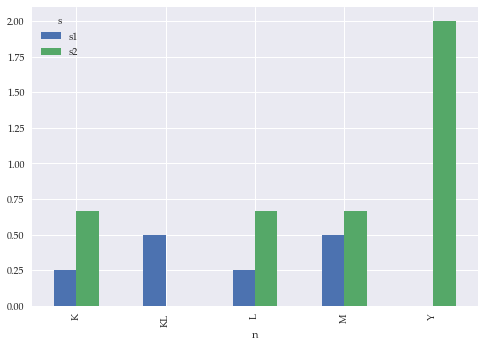

In [6]:
mBasic.out_db.get('qD').xs(1).unstack('s').plot.bar(); # qD measures demand for various components. Index 's' is sectoral, 'n' is indicates which good.

# 3. The intermediate approach

Let's consider the case where we have not yet written the GAMS code for the model. We can use ```GmsWrite, GmsPy``` to automatically write most of the code, given some settings specified. The model we are building is the same as the one from the basic approach above. The workflow for setting up a model in this way can look something like this:
1. Create/load all relevant data using Python and store it in a GpyDB database. Naturally, you can also use other means to arrange your input data - but data management in Python is just really smart compared to e.g. writing the data in the .gms code.
2. Create ```GmsSettings``` class instance. Specify the three core settings for the model:
    1. Define groupings of exogenous and endogenous variables.
    2. Load in gms (or gamY) text that specifies the equations of the model.
    3. Specify what blocks are included in the final model.
3. Compile and run (use automated routines to write final model text).

The following will go into a bit more detail for each step. For now, just note that all it takes to generate the gams text that we eventually used above is the following steps:

In [19]:
db = pyDatabases.GpyDB(db = os.path.join(d['data'], 'ModelTest_A.gdx')) # Add input data
g = GmsPy.GmsSettings(**{'name': 'ModelTest', 'db': db}) # create GmsSettings with the data
with open(os.path.join(d['data'], 'ModelTest_B_Groups'), "rb") as file: # load group specifications
    g.Compile = pickle.load(file)
g['g_exo'] = ['G_ModelTest_A_exo_always', 'G_ModelTest_A_endo_in_calib'] # groups of variables that are exogenous
g['g_endo'] = ['G_ModelTest_A_endo_always', 'G_ModelTest_A_exo_in_calib'] # groups of variables that are endogenous
with open(os.path.join(d['gams'], 'ModelTest_B.gms'), "r") as file: # Equations of the model written in gamY/gams syntax
    blocks = file.read()
g['blocks'] = ['B_ModelTest_B_Tree1', 'B_ModelTest_B_Tree2'] # which blocks should we use in the final model
g['args'].update(g.stdArgs(blocks=blocks)) # write dictionary with components for the final model
g.write(); # write the final model text

### 4. Run

Finally, we run the model as we did in the basic case:

In [15]:
mIntermediate = GmsPy.GmsModel(ws = d['work'], options = {'cns': 'CONOPT4'}) # set up model instance
mIntermediate.addDB(g.db) # add the database to the model - i.e. tell where to load input data from.
mIntermediate.run(''.join(g['text'].values())) # run using the gams text from GmsSettings instance

### 1. Load/create data:*

In [16]:
db = pyDatabases.GpyDB(db = os.path.join(d['data'], 'ModelTest_A.gdx')) # load data from existing file

### 2. Create settings file (with data):

In [8]:
g = GmsPy.GmsSettings(**{'name': 'ModelTest', 'db': db})

#### 2A. Load or specify exogenous and endogenous groups of variables:

We use the classes ```GmsPy.Compile, GmsPy.Group``` to specify the grouping of variables. The notebook [_Compile.ipynb](projects/classes/_Compile.ipynb) goes into more detail on how the groupings can be defined:

In [9]:
with open(os.path.join(d['data'], 'ModelTest_B_Groups'), "rb") as file:
    g.Compile = pickle.load(file)

In this case, all the variables in the model are split into four groups: 
* ```exo_always```: A group of variables that are exogenous in all states of the model.
* ```endo_always```: A group of variables that are endogenous in all states of the model.
* ```exo_in_calib```: A group of variables that are endogenous in the baseline scenario, but exogenous in the calibration state.
* ```endo_in_calib```:  A group of variables that are exogenous in the baseline scenario, but endogenous in the calibration state.

We add these to the ```GmsSettings``` instance by specifying:

In [10]:
g['g_exo'] = ['G_ModelTest_A_exo_always', 'G_ModelTest_A_endo_in_calib']
g['g_endo'] = ['G_ModelTest_A_endo_always', 'G_ModelTest_A_exo_in_calib']

The ```Compile``` class is useful, as it has methods included that writes GAMS code. For instance, the GAMS code needed to fix/unfix all exogenous/endogenous variables:

In [11]:
print(g.Compile.fixGroupsText(db, g['g_exo'].v))
print(g.Compile.unfixGroupsText(db, g['g_endo'].v))

qS.fx[t,s,n]$(((output_ModelTest_A[s,n] and ( not ((endo_qS_ModelTest_A[s,n] and t0[t])))) or (endo_qS_ModelTest_A[s,n] and t0[t]))) = qS.l[t,s,n];
pD.fx[t,s,n]$(input_ModelTest_A[s,n]) = pD.l[t,s,n];
sigma.fx[s,n]$(kninp_ModelTest_A[s,n]) = sigma.l[s,n];
eta.fx[s,n]$(knout_ModelTest_A[s,n]) = eta.l[s,n];
mu.fx[s,n,nn]$((exomu_ModelTest_A[s,n,nn] or ( not (exomu_ModelTest_A[s,n,nn])))) = mu.l[s,n,nn];
pD.lo[t,s,n]$(int_ModelTest_A[s,n]) = -inf;
pD.up[t,s,n]$(int_ModelTest_A[s,n]) = inf;
pS.lo[t,s,n]$((((output_ModelTest_A[s,n] and tx0[t]) or (endo_pS_ModelTest_A[s,n] and t0[t])) or ((output_ModelTest_A[s,n] and t0[t]) and ( not ((endo_pS_ModelTest_A[s,n] and t0[t])))))) = -inf;
pS.up[t,s,n]$((((output_ModelTest_A[s,n] and tx0[t]) or (endo_pS_ModelTest_A[s,n] and t0[t])) or ((output_ModelTest_A[s,n] and t0[t]) and ( not ((endo_pS_ModelTest_A[s,n] and t0[t])))))) = inf;
qD.lo[t,s,n]$(((((int_ModelTest_A[s,n] or input_ModelTest_A[s,n]) and tx0[t]) or (endo_qD_ModelTest_A[s,n] and t0[t])) 

#### 2B. Load in blocks

Here we load in the equations of the model that has been written manually:

In [12]:
with open(os.path.join(d['gams'], 'ModelTest_B.gms'), "r") as file:
    blocks = file.read()
print(blocks)

$BLOCK B_ModelTest_B_Tree1
	E_zp_out_Tree1[t,s,n]$(knot_o_Tree1[s,n] and txE[t])..	pS[t,s,n]*qS[t,s,n] =E= sum(nn$(map_Tree1[s,n,nn]), qD[t,s,nn]*pD[t,s,nn]);
	E_zp_nout_Tree1[t,s,n]$(knot_no_Tree1[s,n] and txE[t])..	pD[t,s,n]*qD[t,s,n] =E= sum(nn$(map_Tree1[s,n,nn]), qD[t,s,nn]*pD[t,s,nn]);
	E_q_out_Tree1[t,s,n]$(branch2o_Tree1[s,n] and txE[t])..	qD[t,s,n] =E= sum(nn$(map_Tree1[s,nn,n]), mu[s,nn,n] * (pS[t,s,nn]/pD[t,s,n])**(sigma[s,nn]) * qS[t,s,nn]);
	E_q_nout_Tree1[t,s,n]$(branch2no_Tree1[s,n] and txE[t])..	qD[t,s,n] =E= sum(nn$(map_Tree1[s,nn,n]), mu[s,nn,n] * (pD[t,s,nn]/pD[t,s,n])**(sigma[s,nn]) * qD[t,s,nn]);
$ENDBLOCK


$BLOCK B_ModelTest_B_Tree2
	E_zp_Tree2[t,s,n]$(knot_Tree2[s,n] and txE[t])..	pD[t,s,n]*qD[t,s,n] =E= sum(nn$(map_Tree2[s,nn,n] and branch_o_Tree2[s,nn]), qS[t,s,nn]*pS[t,s,nn])+sum(nn$(map_Tree2[s,nn,n] and branch_no_Tree2[s,nn]), qD[t,s,nn]*pD[t,s,nn]);
	E_q_out_Tree2[t,s,n]$(branch_o_Tree2[s,n] and txE[t])..	qS[t,s,n] =E= sum(nn$(map_Tree2[s,n,nn]), qD[t,s,nn

#### 2C. Specify model blocks

In our case, the two model blocks are called:

In [13]:
g['blocks'] = ['B_ModelTest_B_Tree1', 'B_ModelTest_B_Tree2']

### 3. Compile

Given the inputs: (1) Database, (2) group of variables, (3) block of equations - the ```GmsSettings``` class can write the gams model by simply calling ```self.stdArgs()```. This creates a dictionary with standard chunks of GAMS code: ```'Root', 'Functions', 'Declare', 'Fix','Unfix','Model','Solve'.``` This is done as follows:

Given the inputs: (1) Database, (2) group of variables, (3) block of equations - the ```GmsSettings``` class can write the gams model by simply calling ```self.stdArgs()```. This creates a dictionary with standard chunks of GAMS code: ```'Root', 'Functions', 'Declare', 'Fix','Unfix','Model','Solve'.``` If we need to use the ```gamY.Precompiler``` to interpret the text from gamY to gams syntax, we also apply the ```self.write``` method:

In [14]:
g['args'].update(g.stdArgs(blocks=blocks)) # Create arguments
g.write(); # write model text

### 4. Run

Finally, we run the model as we did in the basic case:

In [15]:
mIntermediate = GmsPy.GmsModel(ws = d['work'], options = {'cns': 'CONOPT4'}) # set up model instance
mIntermediate.addDB(g.db) # add the database to the model - i.e. tell where to load input data from.
mIntermediate.run(''.join(g['text'].values())) # run using the gams text from GmsSettings instance